In [1]:
%cd /kaggle/working
!git clone https://github.com/ultralytics/yolov5  # clone

/kaggle/working
Cloning into 'yolov5'...
remote: Enumerating objects: 16491, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 16491 (delta 27), reused 36 (delta 9), pack-reused 16408
Receiving objects: 100% (16491/16491), 15.16 MiB | 30.85 MiB/s, done.
Resolving deltas: 100% (11287/11287), done.


In [2]:
%cd /kaggle/working/yolov5
%pip install -qr requirements.txt  # install

/kaggle/working/yolov5
Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
from yolov5 import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v7.0-287-g574331f9 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)


Setup complete ✅ (4 CPUs, 31.4 GB RAM, 5518.9/8062.4 GB disk)


In [4]:
import pandas as pd
import numpy as np
import os
import json
import warnings
warnings.filterwarnings("ignore")
import shutil
import warnings
warnings.filterwarnings("ignore")

In [5]:
# DATAPATH
test_path = "/kaggle/input/Senior-Design-VIAD-4/test"
train_path = "/kaggle/input/Senior-Design-VIAD-4/train"
valid_path = "/kaggle/input/Senior-Design-VIAD-4/valid"
os.mkdir('/kaggle/working/yolov5/data/coco')
os.mkdir('/kaggle/working/yolov5/data/coco/labels')
os.mkdir('/kaggle/working/yolov5/data/coco/images')

In [6]:
# os.listdir('/kaggle/input/Senior-Design-VIAD-4/valid')

In [7]:
def create_labels(path_in,path_out):
    json_files = [file for file in os.listdir(path_in) if file.endswith('.json')]
    
    with open(os.path.join(path_in, json_files[0]), 'r') as f:
        data = json.load(f)
    df_images=pd.DataFrame(data['images'])
    df_images.rename(columns={'id':'image_id'},inplace=True)
    df_categories= pd.DataFrame(data['categories'])
    df_categories.rename(columns={'id':'category_id'},inplace=True)
    df_annotations=pd.DataFrame(data['annotations'])
    merged_df = pd.merge(df_annotations, df_categories, how='left',left_on='category_id', right_on='category_id')
    final_df = pd.merge(merged_df, df_images, how='left', left_on='image_id', right_on='image_id')
    df=final_df[['category_id','bbox','file_name',]]
    df[['bbox_x', 'bbox_y', 'bbox_width', 'bbox_height']] = pd.DataFrame(df['bbox'].apply(lambda x: pd.Series(x)))
    df.drop('bbox', axis=1, inplace=True)
    del df_images, df_categories, df_annotations, merged_df, final_df
    
    
    os.mkdir(f"/kaggle/working/yolov5/data/coco/labels/{path_out}")
    for file_name, group in df.groupby('file_name'):
        # Tạo tên file label
        file_name = file_name[:-3] + "txt"
        label_filename = f"/kaggle/working/yolov5/data/coco/labels/{path_out}/{file_name}"

        # Mở file label để ghi
        with open(label_filename, 'w') as f:
            # Lặp qua từng đối tượng trong ảnh
            for index, row in group.iterrows():
                # Ghi thông tin của mỗi đối tượng vào file label
                class_index = row['category_id']
                x_center = row['bbox_x'] 
                y_center = row['bbox_y'] 
                width = row['bbox_width']
                height = row['bbox_height']

                x_center /= 300
                y_center /= 300
                width /= 300
                height /= 300

                # Ghi thông tin vào file label
                f.write(f"{class_index} {x_center} {y_center} {width} {height}\n")
    print('lable susses')
    files = [file for file in os.listdir(path_in) if not file.endswith('.json')]
    os.mkdir(f"/kaggle/working/yolov5/data/coco/images/{path_out}")

    # Lặp qua từng tệp và sao chép vào thư mục đích
    for file_name in files:
        source_file = os.path.join(path_in, file_name)
        destination_file = os.path.join(f'/kaggle/working/yolov5/data/coco/images/{path_out}', file_name)
        shutil.copy2(source_file, destination_file)
    print('image susses')


In [8]:
# create_labels(test_path,'test')
create_labels(train_path,'train')
create_labels(valid_path,'valid')

lable susses
image susses
lable susses
image susses


In [9]:
# shutil.rmtree(f'/kaggle/working/')


In [10]:
import yaml

# Đường dẫn của thư mục chứa tệp data.yaml
folder_path = '/kaggle/working/yolov5/data/'

# Nội dung của tệp data.yaml
data_yaml_content = {
    'train': '/kaggle/working/yolov5/data/coco/images/train',
    'val': '/kaggle/working/yolov5/data/coco/images/valid',
    'nc': 36,  # Số lượng lớp (number of classes)
    'names': ['cars-bikes-people', 'Bus', 'Bushes', 'Person', 'Truck', 'backpack', 'bench',
             'bicycle', 'boat', 'branch', 'car', 'chair', 'clock', 'crosswalk', 'door',
             'elevator', 'fire_hydrant', 'green_light', 'gun', 'handbag', 'motorcycle',
             'person', 'pothole', 'rat', 'red_light', 'scooter', 'sheep', 'stairs', 'stop_sign',
             'suitcase', 'traffic light', 'traffic_cone', 'train', 'tree', 'truck', 'umbrella',
              'yellow_light']  
}

# Ghi nội dung vào tệp data.yaml
with open(folder_path + 'data.yaml', 'w') as file:
    yaml.dump(data_yaml_content, file)

print("Đã tạo tệp data.yaml thành công.")


Đã tạo tệp data.yaml thành công.


In [11]:
!python train.py --img 320 --batch 10 --epochs 3 --data data.yaml --weights yolov5s.pt --cache

2024-02-28 04:18:48.205737: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-28 04:18:48.205863: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-28 04:18:48.343255: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5s.pt, cfg=, data=data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=3, batch_size=10, imgsz=320, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimiz

In [12]:
!python detect.py --source data/images --weights yolov5s.pt --conf 0.25

detect: weights=['yolov5s.pt'], source=data/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
WARNING ⚠️ invalid check_version(None, >=3.3) requested, please check values.
YOLOv5 🚀 v7.0-287-g574331f9 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
image 1/2 /kaggle/working/yolov5/data/images/bus.jpg: 640x480 4 persons, 1 bus, 54.9ms
image 2/2 /kaggle/working/yolov5/data/images/zidane.jpg: 384x640 2 persons, 2 ties, 53.9ms
Speed: 0.6ms pre-process, 54.4ms inference, 263.3ms NMS per image at shape (1, 3, 640, 640)
Results saved

In [13]:
# import shutil
# import os
input_path = '/kaggle/input/Senior-Design-VIAD-4/test'
output_path = '/kaggle/working/yolov5/data/images'

image_filename = '-13AD8372-CDDB-4DCF-B8F9-DC10D210064B-png_jpg.rf.e8217e5555bb565dc324989173877f5a.jpg'
source_image_path = os.path.join(input_path, image_filename)

# Di chuyển ảnh từ thư mục input vào thư mục output
destination_image_path = os.path.join(output_path, image_filename)
shutil.copy2(source_image_path, destination_image_path)

print("Đã di chuyển ảnh vào thư mục output thành công.")

Đã di chuyển ảnh vào thư mục output thành công.


In [14]:
!python detect.py --source data/images --weights yolov5s.pt --conf 0.25

detect: weights=['yolov5s.pt'], source=data/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
WARNING ⚠️ invalid check_version(None, >=3.3) requested, please check values.
YOLOv5 🚀 v7.0-287-g574331f9 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/3 /kaggle/working/yolov5/data/images/-13AD8372-CDDB-4DCF-B8F9-DC10D210064B-png_jpg.rf.e8217e5555bb565dc324989173877f5a.jpg: 640x640 1 car, 12.3ms
image 2/3 /kaggle/working/yolov5/data/images/bus.jpg: 640x480 4 persons, 1 bus, 52.7ms


In [15]:
!python detect.py --source 

usage: detect.py [-h] [--weights WEIGHTS [WEIGHTS ...]] [--source SOURCE]
                 [--data DATA] [--imgsz IMGSZ [IMGSZ ...]]
                 [--conf-thres CONF_THRES] [--iou-thres IOU_THRES]
                 [--max-det MAX_DET] [--device DEVICE] [--view-img]
                 [--save-txt] [--save-csv] [--save-conf] [--save-crop]
                 [--nosave] [--classes CLASSES [CLASSES ...]] [--agnostic-nms]
                 [--augment] [--visualize] [--update] [--project PROJECT]
                 [--name NAME] [--exist-ok] [--line-thickness LINE_THICKNESS]
                 [--hide-labels] [--hide-conf] [--half] [--dnn]
                 [--vid-stride VID_STRIDE]
detect.py: error: argument --source: expected one argument


In [16]:
display= utils.notebook_init()

YOLOv5 🚀 v7.0-287-g574331f9 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)


Setup complete ✅ (4 CPUs, 31.4 GB RAM, 5518.9/8062.4 GB disk)


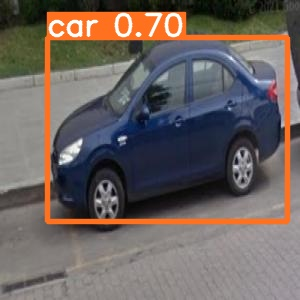

In [17]:
display.Image(filename='/kaggle/working/yolov5/runs/detect/exp2/-13AD8372-CDDB-4DCF-B8F9-DC10D210064B-png_jpg.rf.e8217e5555bb565dc324989173877f5a.jpg')